<a href="https://colab.research.google.com/github/mille055/AIPI540_individual_project/blob/main/notebooks/Train_pixel_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Connect to the data which is in Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#install pydicom for reading the dicom data
!pip install pydicom monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# imports
from __future__ import print_function
import sys
from random import shuffle

import os
import os.path
import glob
import numpy as np
import tensorflow as tf
import csv
import pydicom
import cv2
import configparser
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy

import monai
from monai.data import DataLoader, ImageDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType


In [5]:
data_dir = '/content/gdrive/MyDrive/WW_MRI_abd2/split/'
#train_df = pd.read_pickle(data_dir+'train_img_df.pkl')
#test_df = pd.read_pickle(data_dir+'test_img_df.pkl')
train_csv = pd.read_csv(data_dir + 'trainfiles.csv')
test_csv = pd.read_csv(data_dir + 'testfiles.csv')

#run once at start to rid unneccesary column
train_csv.drop('Unnamed: 0', axis=1, inplace=True)
test_csv.drop('Unnamed: 0', axis=1, inplace=True)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# #train_get_mid = train_csv.groupby(['patientID', 'series']).agg({'img_num': lambda x: sorted(x.to_list())})
# df = train_csv.copy()

# grouped_df = df.groupby(['patientID', 'series'])
# sorted_df = grouped_df['file_info'].apply(lambda x: x.sort_values())
# sorted_df
# middle_filename = grouped_df['file_info'].apply(lambda x: x.sort_values().iloc[len(x)//2])
# middle_filename = middle_filename.reset_index()
# df = df.merge(middle_filename, on=['patientID', 'series'], how='left')
# pd.options.display.max_colwidth = 100
# train_csv_short = df.drop(['file_info_x', 'img_num'], axis=1)
# train_csv_short.rename(columns = {'file_info_y': 'file_info'})
# train_csv_short.drop_duplicates(inplace=True)
# train_csv_short





In [7]:
# this function will select the image in the middle of each series of images, so that only a single image from each series is selected for training
# There is one image from each series for each patient
def shorten_df(df, selection_fraction = 0.5):
  df1 = df.copy()
  grouped_df = df.groupby(['patientID', 'series'])
  sorted_df = grouped_df['file_info'].apply(lambda x: x.sort_values())
  
  selected_filename = grouped_df['file_info'].apply(lambda x: x.sort_values().iloc[int(len(x)*selection_fraction)])

  
  selected_filename = selected_filename.reset_index()
  
  # perform merge and deal with duplicate/unnecessary columns
  df1 = df1.merge(selected_filename, on=['patientID', 'series'], how='left') 
  df_short = df1.drop(['file_info_x', 'img_num'], axis=1)
  df_short = df_short.rename(columns = {'file_info_y': 'file_info'})
  df_short.drop_duplicates(inplace=True)
  df_short.reset_index(drop=True, inplace=True)
  return df_short

In [8]:
# create shortened dataframes for train and test
train_csv_short = shorten_df(train_csv, selection_fraction = 0.5)
test_csv_short = shorten_df(test_csv, selection_fraction = 0.5)


In [9]:
test_csv_short

,label,patientID,series,file_info
0,8,102,16(1-40),/volumes/cm7/Abdominal_MRI_dataset_split/test/...
1,8,102,16(41-80),/volumes/cm7/Abdominal_MRI_dataset_split/test/...
2,16,102,18,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
3,3,102,11,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
4,25,102,7,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
...,...,...,...,...
441,8,58,16(1-36),/volumes/cm7/Abdominal_MRI_dataset_split/test/...
442,7,58,2,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
443,2,58,13,/volumes/cm7/Abdominal_MRI_dataset_split/test/...
444,14,58,5,/volumes/cm7/Abdominal_MRI_dataset_split/test/...


In [10]:
train_csv_short

,label,patientID,series,file_info
0,8,104,18(35-68),/volumes/cm7/Abdominal_MRI_dataset_split/train...
1,8,104,18(1-34),/volumes/cm7/Abdominal_MRI_dataset_split/train...
2,16,104,20,/volumes/cm7/Abdominal_MRI_dataset_split/train...
3,9,104,9,/volumes/cm7/Abdominal_MRI_dataset_split/train...
4,9,104,11,/volumes/cm7/Abdominal_MRI_dataset_split/train...
...,...,...,...,...
1761,7,94,3,/volumes/cm7/Abdominal_MRI_dataset_split/train...
1762,2,94,12,/volumes/cm7/Abdominal_MRI_dataset_split/train...
1763,2,94,13,/volumes/cm7/Abdominal_MRI_dataset_split/train...
1764,19,94,5,/volumes/cm7/Abdominal_MRI_dataset_split/train...


In [22]:
#create train, val, and test datasets from the csv files, using same val list as metadata classifier

#using same train/val/test split as in the original split based on the metadata classifier
val_list = [41, 84, 14, 25, 76, 47,62,0,55,63,101,18,81,3,4,95,66]

val_df = train_csv_short[train_csv_short.patientID.isin(val_list)]
train_df = train_csv_short[~train_csv_short.index.isin(val_df.index)]
test_df = test_csv_short

## exclude the nonclinical and infrequent series to match the metadata model
exclusion_labels = [21,22,26,27,28,29]
val_df = val_df[~val_df.label.isin(exclusion_labels)]
train_df = train_df[~train_df.label.isin(exclusion_labels)]
test_df = test_df[~test_df.label.isin(exclusion_labels)]

train = train_df.reset_index(drop=True)
val = val_df.reset_index(drop=True)
test = test_df.reset_index(drop=True)

#sanity check
print(len(val)+len(train), len(test))
display(val.head(), train.head())

1725 432


,label,patientID,series,file_info
0,8,41,16(37-72),/volumes/cm7/Abdominal_MRI_dataset_split/train...
1,16,41,18,/volumes/cm7/Abdominal_MRI_dataset_split/train...
2,3,41,11,/volumes/cm7/Abdominal_MRI_dataset_split/train...
3,25,41,7,/volumes/cm7/Abdominal_MRI_dataset_split/train...
4,11,41,6,/volumes/cm7/Abdominal_MRI_dataset_split/train...


,label,patientID,series,file_info
0,8,104,18(35-68),/volumes/cm7/Abdominal_MRI_dataset_split/train...
1,8,104,18(1-34),/volumes/cm7/Abdominal_MRI_dataset_split/train...
2,16,104,20,/volumes/cm7/Abdominal_MRI_dataset_split/train...
3,9,104,9,/volumes/cm7/Abdominal_MRI_dataset_split/train...
4,9,104,11,/volumes/cm7/Abdominal_MRI_dataset_split/train...


In [23]:
# Data cropping and normalization, also converts single channel to 3 channel for the model
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        #transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [24]:
# custom datasest - gets the image data using pydicom.dcmread and transforms
# also gets label from the label column and merges classes 2-5 which are all flavors
# arterial into a single 'arterial' label as label 2

class ImgDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.file_info
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
        source = '/volumes/cm7/Abdominal_MRI_dataset_split/'
        dest = '/content/gdrive/MyDrive/WW_MRI_abd2/split/'

        img_file = self.data_df.file_info[idx]
        rel = os.path.relpath(img_file, source)
        img_file_new = os.path.join(dest,rel)
        
        #print('getting file', img_file)
        ds = pydicom.dcmread(img_file_new)
        img = np.array(ds.pixel_array, dtype=np.float32)
        #img = img/255.
        #img = cv2.resize(img, (224,224))
        img = img[np.newaxis]
        img = torch.from_numpy(np.asarray(img))
        
        #print(img.dtype, img.shape)
        
        
        if self.transform:
            img = self.transform(img)
        #print('after transform', img.dtype, img.shape)
            
        x = img
        labl = self.data_df.label[idx]
      
        if labl in [2,3,4,5]: 
          labl=2
        y = torch.tensor(labl, dtype = torch.float32)
        #print(x,y)
        return (x,y)
        

In [25]:
#dataloaders
train_imgdata = ImgDataset(train, data_transforms['train'])
train_loader = DataLoader(train_imgdata, batch_size=8, shuffle=True)

val_imgdata = ImgDataset(val, data_transforms['val'])
val_loader = DataLoader(val_imgdata, batch_size=8, shuffle=True)

test_imgdata = ImgDataset(test, data_transforms['test'])
test_loader = DataLoader(test_imgdata, batch_size=8, shuffle=False)

dataset_sizes = {'train':len(train_imgdata),'val':len(val_imgdata)}


In [26]:
#visualization
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)

    plt.axis('off')
    plt.show()

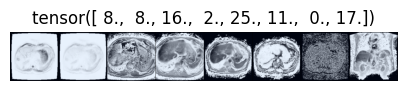

In [27]:
test_next_batch = next(iter(test_loader))
#print(train_next_batch[0])
imshow(test_next_batch[0], (test_next_batch[1]))

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_num = 0
            for inputs, labels in dataloaders[phase]:
                print('batch ', batch_num)
                batch_num= batch_num + 1
                inputs = inputs.to(device)
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
                
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [30]:
# use resnet50 transfer learning
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# output
model_ft.fc = nn.Linear(num_ftrs, 30)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [31]:
# train model for 25 epochs
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Streaming output truncated to the last 5000 lines.
batch  106
batch  107
batch  108
batch  109
batch  110
batch  111
batch  112
batch  113
batch  114
batch  115
batch  116
batch  117
batch  118
batch  119
batch  120
batch  121
batch  122
batch  123
batch  124
batch  125
batch  126
batch  127
batch  128
batch  129
batch  130
batch  131
batch  132
batch  133
batch  134
batch  135
batch  136
batch  137
batch  138
batch  139
batch  140
batch  141
batch  142
batch  143
batch  144
batch  145
batch  146
batch  147
batch  148
batch  149
batch  150
batch  151
batch  152
batch  153
batch  154
batch  155
batch  156
batch  157
batch  158
batch  159
batch  160
batch  161
batch  162
batch  163
batch  164
batch  165
batch  166
batch  167
batch  168
batch  169
batch  170
batch  171
train Loss: 0.4971 Acc: 0.8446
batch  0
batch  1
batch  2
batch  3
batch  4
batch  5
batch  6
batch  7
batch  8
batch  9
batch  10
batch  11
batch  12
batch  13
batch  14
batch  15
batch  16
batch  17
batch  18
batch  19
ba

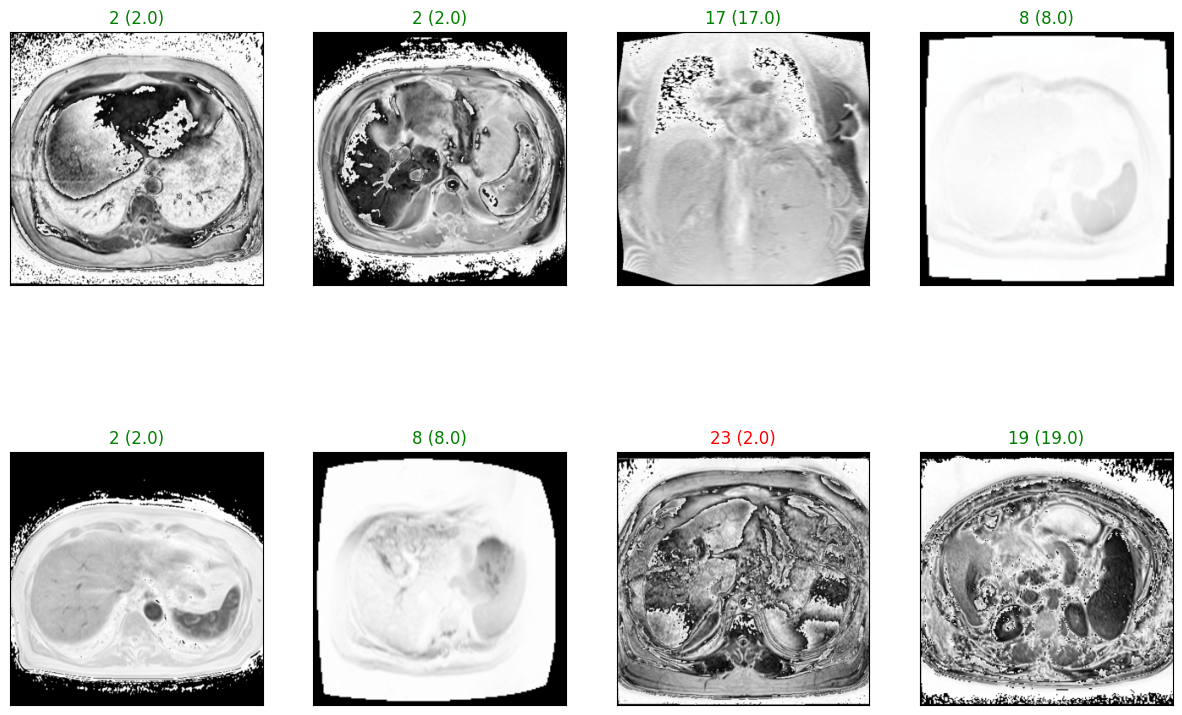

In [32]:
# Display a batch of predictions

def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(val_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (std * image + mean)
        
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(preds[idx], labels[idx]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(model_ft,val_loader,device)

In [33]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)
            #print(labels, logits.sum())
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = torch.softmax(logits, dim=1)
            probs = probs.detach().cpu().numpy()
            #print(labels, probs)
            # Get discrete predictions using argmax
            preds = np.argmax(probs,axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels.detach().cpu().numpy())

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(30):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals, test_preds, y_true

In [34]:
# Test the pre-trained model
#classes = set(train.label)
acc,recall_vals, test_preds, ytrue = test_model(model_ft,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))


for i in range(len(recall_vals)):
    print('For class {}, recall is {}'.format(i,recall_vals[i]))

Test set accuracy is 0.905
For class 0, recall is 1.0
For class 1, recall is nan
For class 2, recall is 0.9180327868852459
For class 3, recall is nan
For class 4, recall is nan
For class 5, recall is nan
For class 6, recall is 1.0
For class 7, recall is 1.0
For class 8, recall is 1.0
For class 9, recall is 1.0
For class 10, recall is nan
For class 11, recall is 0.896551724137931
For class 12, recall is 0.1
For class 13, recall is 0.0
For class 14, recall is 0.9130434782608695
For class 15, recall is nan
For class 16, recall is 0.5909090909090909
For class 17, recall is 1.0
For class 18, recall is 1.0
For class 19, recall is 0.9565217391304348
For class 20, recall is nan
For class 21, recall is nan
For class 22, recall is nan
For class 23, recall is 0.75
For class 24, recall is nan
For class 25, recall is 0.9148936170212766
For class 26, recall is nan
For class 27, recall is nan
For class 28, recall is nan
For class 29, recall is nan


<ipython-input-33-0f1e62d1e0be>:40: RuntimeWarning: invalid value encountered in long_scalars
  recall = correct / total


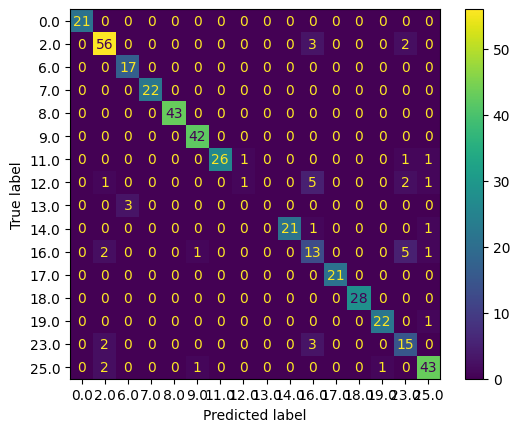

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
ConfusionMatrixDisplay.from_predictions(ytrue, test_preds)

<Figure size 2500x2500 with 0 Axes>

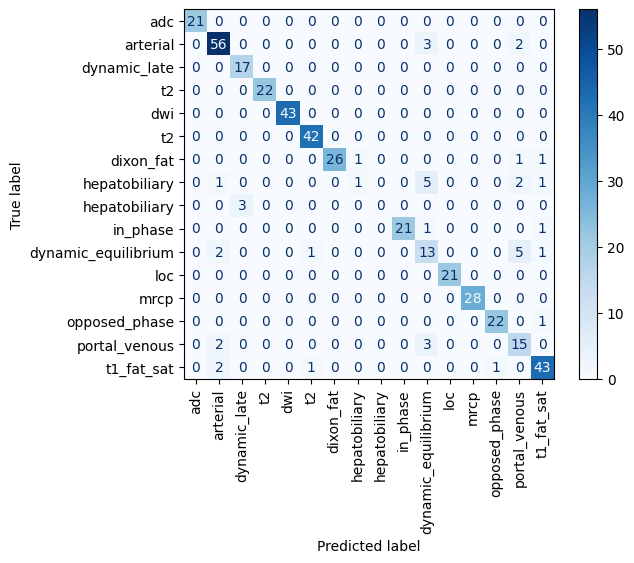

In [36]:
from datetime import datetime
abd_label_dict_updated = {
    '1': {
        'long': 'Anythingelse',
        'short': 'other',
        'plane': 'other',
        'contrast': 'other'
    },
    '2': {
        'long': 'Arterial T1w',
        'short': 'arterial',
        'plane': 'ax',
        'contrast': '1'
    },
    '3': {
        'long': 'Early Arterial T1w',
        'short': 'early_arterial',
        'plane': 'ax',
        'contrast': '1'
    },
    '4': {
        'long': 'Late Arterial T1w',
        'short': 'late_arterial',
        'plane': 'ax',
        'contrast': '1'
    },
    '5': {
        'long': 'Arterial Subtraction',
        'short': 'arterial_sub',
        'plane': 'ax',
        'contrast': '1'
    },
    '6': {
        'long': 'Coronal Late Dynamic T1w',
        'short': 'dynamic_late',
        'plane': 'cor',
        'contrast': '1'
    },
    '7': {
        'long': 'Coronal T2w',
        'short': 't2',
        'plane': 'cor',
        'contrast': '0'
    },
    '8': {
        'long': 'Axial DWI',
        'short': 'dwi',
        'plane': 'ax',
        'contrast': '0'
    },
    '9': {
        'long': 'Axial T2w',
        'short': 't2',
        'plane': 'ax',
        'contrast': '0'
    },
    '10': {
        'long': 'Coronal DWI',
        'short': 'dwi',
        'plane': 'cor',
        'contrast': '0'
    },
    '11': {
        'long': 'Fat Only',
        'short': 'dixon_fat',
        'plane': 'ax',
        'contrast': '0'
    },
    '12': {
        'long': 'Axial Transitional_Hepatocyte T1w',
        'short': 'hepatobiliary',
        'plane': 'ax',
        'contrast': '1'
    },
    '13': {
        'long': 'Coronal Transitional_Hepatocyte T1w',
        'short': 'hepatobiliary',
        'plane': 'cor',
        'contrast': '1'
    },
    '14': {
        'long': 'Axial In Phase',
        'short': 'in_phase',
        'plane': 'ax',
        'contrast': '0'
    },
    '15': {
        'long': 'Coronal In Phase',
        'short': 'in_phase',
        'plane': 'cor',
        'contrast': '0'
    },
    '16': {
        'long': 'Axial Late Dyanmic T1w',
        'short': 'dynamic_equilibrium',
        'plane': 'ax',
        'contrast': '1'
    },
    '17': {
        'long': 'Localizers',
        'short': 'loc',
        'plane': 'unknown',
        'contrast': '0'
    },
    '18': {
        'long': 'MRCP',
        'short': 'mrcp',
        'plane': 'cor',
        'contrast': '0'
    },
    '19': {
        'long': 'Axial Opposed Phase',
        'short': 'opposed_phase',
        'plane': 'ax',
        'contrast': '0'
    },
    '20': {
        'long': 'Coronal Opposed Phase',
        'short': 'opposed_phase',
        'plane': 'cor',
        'contrast': '0'
    },
    '21': {
        'long': 'Proton Density Fat Fraction',
        'short': 'fat_quant',
        'plane': 'ax',
        'contrast': '0'
    },
    '22': {
        'long': 'Water Density Fat Fraction',
        'short': 'water_fat_quant',
        'plane': 'ax',
        'contrast': '0'
    },
    '23': {
        'long': 'Portal Venous T1w',
        'short': 'portal_venous',
        'plane': 'ax',
        'contrast': '1'
    },
    '24': {
        'long': 'Coronal Precontrast Fat Suppressed T1w',
        'short': 't1_fat_sat',
        'plane': 'cor',
        'contrast': '0'
    },
    '25': {
        'long': 'Axial Precontrast Fat Suppressed T1w',
        'short': 't1_fat_sat',
        'plane': 'ax',
        'contrast': '0'
    },
    '26': {
        'long': 'R*2',
        'short': 'r_star_2',
        'plane': 'ax',
        'contrast': '0'
    },
    '27': {
        'long': 'Axial Steady State Free Precession',
        'short': 'ssfse',
        'plane': 'ax',
        'contrast': '0'
    },
    '28': {
        'long': 'Coronal Steady State Free Precession',
        'short': 'ssfse',
        'plane': 'cor',
        'contrast': '1'
    },
    '29': {
        'long': 'Venous Subtraction',
        'short': 'venous_sub',
        'plane': 'ax',
        'contrast': '1'
    },
    '0': {
        'long': 'Axial ADC',
        'short': 'adc',
        'plane': 'ax',
        'contrast': '0'
    },
     '30': {
        'long': 'Axial Post Contrast Fat Suppressed T1w',
        'short': 't1_fat_sat',
        'plane': 'ax',
        'contrast': '1'
    },
    '31': {
        'long': 'Coronal Post Contrast Fat Suppressed T1w',
        'short': 't1_fat_sat',
        'plane': 'cor',
        'contrast': '1'
    },
    '32': {
        'long': 'Post Contrast Fat Suppressed T1w',
        'short': 't1_fat_sat',
        'plane': 'ax/cor',
        'contrast': '1'
    }
}
yvals= set(list(ytrue))
yvals = [str(int(x)) for x in yvals]

target_names = [abd_label_dict_updated[str(x)] ['short'] for x in yvals]
cm = confusion_matrix(ytrue, test_preds)
plt.figure(figsize=(25, 25))
plt.tight_layout()
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(xticks_rotation = 'vertical', cmap='Blues')
plt.savefig("FigPixel"+datetime.now().strftime('%Y%m%d')+".png",dpi=300, bbox_inches = 'tight')

In [37]:
print(classification_report(ytrue, test_preds))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        21
         2.0       0.89      0.92      0.90        61
         6.0       0.85      1.00      0.92        17
         7.0       1.00      1.00      1.00        22
         8.0       1.00      1.00      1.00        43
         9.0       0.95      1.00      0.98        42
        11.0       1.00      0.90      0.95        29
        12.0       0.50      0.10      0.17        10
        13.0       0.00      0.00      0.00         3
        14.0       1.00      0.91      0.95        23
        16.0       0.52      0.59      0.55        22
        17.0       1.00      1.00      1.00        21
        18.0       1.00      1.00      1.00        28
        19.0       0.96      0.96      0.96        23
        23.0       0.60      0.75      0.67        20
        25.0       0.90      0.91      0.91        47

    accuracy                           0.91       432
   macro avg       0.82   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
# ### save the model from this training run
# import pickle
# pickle.dump(model_ft, open('pixel_model_single_img_032123.pkl', 'wb'))

In [39]:
# Save the model's state_dict
torch.save(model_ft.state_dict(), 'pixel_model_041123.pth')

In [40]:
test2_csv_short = shorten_df(test_csv, 0.75)
test2 = test2_csv_short.reset_index(drop=True)

In [41]:
test_imgdata2 = ImgDataset(test2, data_transforms['test'])
test_loader2 = DataLoader(test_imgdata2, batch_size=8, shuffle=False)

In [42]:
#testing model trained on images with selection = 0.3 with test where selection = 0.5
# Test the pre-trained model
#classes = set(train.label)
acc2,recall_vals2, test_preds2, ytrue2 = test_model(model_ft,test_loader2,device)
print('Test set accuracy is {:.3f}'.format(acc))


for i in range(len(recall_vals)):
    print('For class {}, recall is {}'.format(i,recall_vals[i]))

In [ ]:

ConfusionMatrixDisplay.from_predictions(ytrue, test_preds2)

print(classification_report(ytrue, test_preds2))

In [ ]:
model_dn = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

model_dn.fc = nn.Linear(num_ftrs, 30)
model_dn = model_dn.to(device)

In [ ]:
model_dn = train_model(model_dn, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


In [ ]:
# Test the pre-trained model
#classes = set(train.label)
acc,recall_vals, test_preds, ytrue = test_model(model_ft,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))


for i in range(len(recall_vals)):
    print('For class {}, recall is {}'.format(i,recall_vals[i]))

In [ ]:
model_iv3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_iv3.fc = nn.Linear(num_ftrs, 30)

model_iv3 = model_iv3.to(device)

In [ ]:
model_iv3 = train_model(model_iv3, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

In [ ]:
torch.save(model_ft.state_dict(), 'model_res50sel0_3')

In [ ]:
model_ft

In [ ]:
# # Define monai transforms
# train_trans_mon = Compose([ScaleIntensity(),  Resize((1, 299, 299)), RandRotate90(), EnsureType()])
# val_trans_mon = Compose([ScaleIntensity(), Resize((1, 299, 299)), EnsureType()])

# # Create training Dataset and DataLoader using first 10 images
# train_ds = ImageDataset(image_files=images[:10], labels=labels[:10], transform=train_trans_mon)
# train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# # Create validation Dataset and DataLoader using the rest of the images
# val_ds = ImageDataset(image_files=images[-10:], labels=labels[-10:], transform=val_transforms)
# val_loader = DataLoader(val_ds, batch_size=2, num_workers=2, pin_memory=torch.cuda.is_available())

# # Set up dict for dataloaders
# dataloaders = {'train':train_loader,'val':val_loader}

# # Store size of training and validation sets
# dataset_sizes = {'train':len(train_ds),'val':len(val_ds)}

# im, label = monai.utils.misc.first(train_loader)
# print(f'Image type: {type(im)}')
# print(f'Input batch shape: {im.shape}')
# print(f'Label batch shape: {label.shape}')

In [ ]:
model_mon = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=1, out_channels=30).to(device)

In [ ]:
# Use cross-entropy loss function
criterion = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

# Use Adam adaptive optimizer
optimizer = torch.optim.Adam(model_mon.parameters(), 1e-4)

# Train the model
epochs=10
model_mon = train_model(model_mon, criterion, optimizer, exp_lr_scheduler, num_epochs=epochs)